# IPL Match Predictor

### Brief:
* Build a simple Logistic Regression based prediction model that calculates the winning probability in percentage for the chasing team provided information on playing teams, target, overs, etc.
* We plan to predict the output in terms of a winning and losing percentage. Hence, we prefer to build our model on classification algorithms which returns us the probability in percentage like Logistic Regression or SVM.
* We could also use a 'Random Forest Classifier' for higher accuracy but it doesnt give percentage probabilities in a desired way.


#### Download the dataset here
https://www.kaggle.com/ramjidoolla/ipl-data-set

In [1]:
#importing dependencies 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
match = pd.read_csv(r'C:\Users\Aswathi\Downloads\IPL Win Prediction Model\ipl predictor data\matches.csv')
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [3]:
match.shape

(756, 18)

In [4]:
match.columns

Index(['id', 'Season', 'city', 'date', 'team1', 'team2', 'toss_winner',
       'toss_decision', 'result', 'dl_applied', 'winner', 'win_by_runs',
       'win_by_wickets', 'player_of_match', 'venue', 'umpire1', 'umpire2',
       'umpire3'],
      dtype='object')

In [5]:
match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               756 non-null    int64 
 1   Season           756 non-null    object
 2   city             749 non-null    object
 3   date             756 non-null    object
 4   team1            756 non-null    object
 5   team2            756 non-null    object
 6   toss_winner      756 non-null    object
 7   toss_decision    756 non-null    object
 8   result           756 non-null    object
 9   dl_applied       756 non-null    int64 
 10  winner           752 non-null    object
 11  win_by_runs      756 non-null    int64 
 12  win_by_wickets   756 non-null    int64 
 13  player_of_match  752 non-null    object
 14  venue            756 non-null    object
 15  umpire1          754 non-null    object
 16  umpire2          754 non-null    object
 17  umpire3          119 non-null    ob

**Initial Dimensionality Reduction**

Since we are predicting the winning probability, we certainly don't need the following columns at the first look itself:
* umpire1, umpire2, umpire3
* player_of_match
* date 
* Season
* Venue (since there is another similar feature 'city'.)

Hence, we will drop them

In [6]:
match.drop(['Season','date','player_of_match','umpire1', 'umpire2', 'umpire3','venue'], axis = 1, inplace=True)
match.shape

(756, 11)

In [7]:
#loading delivery dataset
deliv = pd.read_csv(r'C:\Users\Aswathi\Downloads\IPL Win Prediction Model\ipl predictor data\deliveries.csv')
deliv.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


* The delivery dataset contains ball by ball (delivery is a ball in an over in cricket) data of every innings in every match of IPL

### Choosing the Features for Modelling
To calculate the win proability, we will take few of the already existing features in both the csv files as well as devise some new features from the existing data. As per the knowledge from the Domain of Cricket, the following will be great in training a model that could predict the result of the match:
1. batting_team
2. bowling_team
3. city (where the match is happening - whether home or away, condition of the pitch, etc. affects the result)
4. chasing score (how much more run is required after each delivery) [new feature]
5. balls left [new feature]
6. wickets_left [new feature]
7. target score [new feature]
8. c_runrate [new feature]
9. r_runrate [new feature] 
10. result [class label - win or lose] - we have this data in the matches dataset

In [8]:
#lets first find out how much score is made in every inning in every match using the delivery dataset
#we have to go for total_runs (not batsman_runs)

In [9]:
scoredf = deliv.groupby(['match_id','inning']).sum()['total_runs'].reset_index()
scoredf

,match_id,inning,total_runs
0,1,1,207
1,1,2,172
2,2,1,184
3,2,2,187
4,3,1,183
...,...,...,...
1523,11413,2,170
1524,11414,1,155
1525,11414,2,162
1526,11415,1,152


In [10]:
#now, to train the model, we will give it only the target score (that is the score of the first innings plus 1)
#the chase happens based on this target score and we will never know what the 2nd team will score until the end of the game
#but we have to predict the probability while the 2nd innings progresses 

In [11]:
#we remove the scores that belong to 2nd innings 
scoredf = scoredf[scoredf['inning']==1]
scoredf

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [12]:
#now we will merge dfmatches with dfscore by 'match_id' and 'id 
#merging is done to know how much the first_batting team score in every match 
matchdf = match.merge(scoredf[['match_id','total_runs']], left_on = 'id', right_on = 'match_id')
matchdf

,id,city,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,match_id,total_runs
0,1,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,1,207
1,2,Pune,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,2,184
2,3,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,3,183
3,4,Indore,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,4,163
4,5,Bangalore,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,Mumbai,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,11347,143
752,11412,Chennai,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,11412,136
753,11413,Visakhapatnam,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,11413,171
754,11414,Visakhapatnam,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,11414,155


In [13]:
#Not all teams played all the seasons of IPL from 2008-2019 in the dataset
#we remove teams which didnt play all seasons 
#few teams also change there names in between - we keep only the latest name
matchdf['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [14]:
#we create a seperate list of team that is to be included
#we also replace the names of old names 

teamlist = ['Sunrisers Hyderabad', 'Mumbai Indians',
            'Royal Challengers Bangalore','Kolkata Knight Riders', 
            'Delhi Capitals', 'Kings XI Punjab',
            'Chennai Super Kings', 'Rajasthan Royals' 
            ]

In [15]:
#code to replace names of 'delhi daredevils' and 'deccan chargers'
matchdf['team1'] = matchdf['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
matchdf['team2'] = matchdf['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

matchdf['team1'] = matchdf['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
matchdf['team2'] = matchdf['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

In [16]:
matchdf['team1'].unique()
#we see that delhi capitals and sunrisers have replaced delhi daredevils and deccan chargers 

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Capitals', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Kochi Tuskers Kerala',
       'Pune Warriors', 'Rising Pune Supergiants'], dtype=object)

In [17]:
#filtering out the non-playing teams 
matchdf = matchdf[matchdf['team1'].isin(teamlist)]
matchdf = matchdf[matchdf['team2'].isin(teamlist)]

In [18]:
matchdf['team1'].unique()

array(['Sunrisers Hyderabad', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Kings XI Punjab', 'Delhi Capitals',
       'Mumbai Indians', 'Chennai Super Kings', 'Rajasthan Royals'],
      dtype=object)

In [19]:
#we now have only the regular playing 8 ipl teams
#the new filtered df is has lesser rows
matchdf.shape

(641, 13)

In [20]:
#now lets check cases of results
matchdf['result'].unique()

array(['normal', 'tie', 'no result'], dtype=object)

In [21]:
matchdf['result'].value_counts()

normal       630
tie            8
no result      3
Name: result, dtype: int64

In [22]:
matchdf['dl_applied'].unique()

array([0, 1], dtype=int64)

In [23]:
matchdf['dl_applied'].value_counts()
#there are 15 matches where Duckworth Lewis method was applied 
#we will remove these matches 

0    626
1     15
Name: dl_applied, dtype: int64

* We will only consider cases where-in there have been a normal result and ties as the 'No Result' cases are rare or biased due to natural phenomenons like Rain.
* Hence we will drop 'no_result' matches and matches where-in 'dl_applied' is 1.

In [24]:
matchdf = matchdf[matchdf['dl_applied'] == 0]
matchdf['dl_applied'].value_counts()
#we removed those 15 matches

0    626
Name: dl_applied, dtype: int64

In [25]:
#we will also remove the no_result matches 
matchdf['result'].value_counts()

normal       615
tie            8
no result      3
Name: result, dtype: int64

In [26]:
matchdf = matchdf[matchdf['result'] != 'no result']
matchdf['result'].value_counts()

normal    615
tie         8
Name: result, dtype: int64

In [27]:
matchdf.shape

(623, 13)

In [28]:
#finally, we have 623 rows
#we initially had 756 rows 
print("{}% of data has been retained.".format(round((623/756)*100,2)))
print("{}% of data has been removed during preprocessing.".format(round(((756-623)/756)*100,2)))

82.41% of data has been retained.
17.59% of data has been removed during preprocessing.


In [29]:
#now, we filter out the necessary columns from matchdf and then merge it with delivery data that we loaded earlier

In [30]:
matchdf.columns

Index(['id', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'result', 'dl_applied', 'winner', 'win_by_runs', 'win_by_wickets',
       'match_id', 'total_runs'],
      dtype='object')

In [31]:
#we use city, matchid, winner and total_runs from the dataframe to merge with delivery data 
matchdf = matchdf[['match_id','city','winner', 'total_runs']]
matchdf.columns

Index(['match_id', 'city', 'winner', 'total_runs'], dtype='object')

In [32]:
#merging matchdf and deliv df
delivdf = matchdf.merge(deliv, on = 'match_id')
delivdf

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
0,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,...,0,0,0,0,0,2,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149265,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149266,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149267,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [33]:
#now, we will filter out the deliveries bowled in the 2nd innings 
delivdf = delivdf[delivdf['inning'] == 2]
delivdf

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149265,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149266,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149267,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [34]:
#now, we have to add +1 to the total_score to set it as the required target that the 2nd batting team chases 
delivdf['total_runs_x'] = delivdf['total_runs_x'] + 1

In [35]:
#we rename total_runs as target_score 
delivdf.rename(columns = {'total_runs_x':'target_score'}, inplace = True)
delivdf.head(4)

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [36]:
#now we will calculate live runs score based on the runs scored every ball
#total_y column stores the total runs scored in every delivery
#we take a cumulative sum of the total_runs to get the score 
delivdf['curr_score'] = delivdf.groupby('match_id').cumsum()['total_runs_y']
delivdf.head()

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,1,0,1,NaN,NaN,NaN,1
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,NaN,NaN,NaN,1
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,NaN,NaN,NaN,1
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,2,0,2,NaN,NaN,NaN,3
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,4,0,4,NaN,NaN,NaN,7


In [37]:
delivdf['runs_reqd'] = (delivdf['target_score'] - delivdf['curr_score'])
delivdf.head()

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,1,0,1,NaN,NaN,NaN,1,207
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,1,207
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,1,207
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,2,0,2,NaN,NaN,NaN,3,205
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,4,0,4,NaN,NaN,NaN,7,201


In [38]:
#similarly, we will reduce balls from the total number of balls (120 balls per innings) to find out number of balls 

In [39]:
#we device a formula that keeps tracks the number of balls using a combination of values from over and balls columns 

delivdf['balls_rem'] = 126 - (delivdf['over']*6 + delivdf['ball'])
delivdf

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd,balls_rem
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,207,119
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,207,118
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,207,117
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,205,116
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,201,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,1,4
149265,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-1,3
149266,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-2,2
149267,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-4,1


In [40]:
#now we have to get the wickets left - track it according to falls of wickets based on player_dismissed column

In [41]:
#we first replace the NaN values in player_dismissed column with "0" 
delivdf['player_dismissed'] = delivdf['player_dismissed'].fillna("0")

#we apply a function to replace the name of the player_dismissed with 1
delivdf['player_dismissed'] = delivdf['player_dismissed'].apply(lambda val:val if val == "0" else "1")

#convert the values of player_dismissed column to int for counting the wickets fallen
delivdf['player_dismissed'] = delivdf['player_dismissed'].astype('int')

In [42]:
#now we find the number of wickets after each ball 
wkt_fall = delivdf.groupby('match_id').cumsum()['player_dismissed'].values
delivdf['wkts_left'] = 10 - wkt_fall
delivdf

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd,balls_rem,wkts_left
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,207,119,10
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,207,118,10
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,207,117,10
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,205,116,10
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,201,115,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,1,0,1,0,NaN,NaN,152,1,4,5
149265,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,2,0,2,0,NaN,NaN,154,-1,3,5
149266,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,1,0,1,1,run out,KH Pandya,155,-2,2,4
149267,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,2,0,2,0,NaN,NaN,157,-4,1,4


In [43]:
#now, we need to get the runrates - current runrate and required runrate
#c_runrate = runs_scored / number of balls bowled
#r_runrate = runs_reqd / number of balls left

In [44]:
delivdf['c_runrate'] = round((delivdf['curr_score']/ ((120 - delivdf['balls_rem'])/6)),2)
delivdf

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd,balls_rem,wkts_left,c_runrate
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,NaN,NaN,1,207,119,10,6.00
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,NaN,NaN,1,207,118,10,3.00
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,NaN,NaN,1,207,117,10,2.00
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,NaN,NaN,3,205,116,10,4.50
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,NaN,NaN,7,201,115,10,8.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,NaN,NaN,152,1,4,5,7.86
149265,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,NaN,NaN,154,-1,3,5,7.90
149266,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,1,run out,KH Pandya,155,-2,2,4,7.88
149267,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,NaN,NaN,157,-4,1,4,7.92


In [45]:
delivdf['r_runrate'] = round(delivdf['runs_reqd']/ (delivdf['balls_rem']/6),2)
delivdf

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,total_runs_y,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,NaN,NaN,1,207,119,10,6.00,10.44
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,NaN,NaN,1,207,118,10,3.00,10.53
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,NaN,NaN,1,207,117,10,2.00,10.62
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,NaN,NaN,3,205,116,10,4.50,10.60
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,NaN,NaN,7,201,115,10,8.40,10.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,1,0,NaN,NaN,152,1,4,5,7.86,1.50
149265,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,2,0,NaN,NaN,154,-1,3,5,7.90,-2.00
149266,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,1,1,run out,KH Pandya,155,-2,2,4,7.88,-6.00
149267,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,2,0,NaN,NaN,157,-4,1,4,7.92,-24.00


In [46]:
#result in terms of 0 or 1
def result(mat):
    return 1 if mat['batting_team'] == mat['winner'] else 0
    

In [47]:
delivdf['match_result'] = delivdf.apply(result, axis=1)
delivdf

,match_id,city,winner,target_score,inning,batting_team,bowling_team,over,ball,batsman,...,player_dismissed,dismissal_kind,fielder,curr_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
125,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,NaN,NaN,1,207,119,10,6.00,10.44,0
126,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,NaN,NaN,1,207,118,10,3.00,10.53,0
127,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,NaN,NaN,1,207,117,10,2.00,10.62,0
128,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,NaN,NaN,3,205,116,10,4.50,10.60,0
129,1,Hyderabad,Sunrisers Hyderabad,208,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,NaN,NaN,7,201,115,10,8.40,10.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149264,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,NaN,NaN,152,1,4,5,7.86,1.50,0
149265,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,NaN,NaN,154,-1,3,5,7.90,-2.00,0
149266,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,1,run out,KH Pandya,155,-2,2,4,7.88,-6.00,0
149267,11415,Hyderabad,Mumbai Indians,153,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,NaN,NaN,157,-4,1,4,7.92,-24.00,0


In [48]:
#now we have all the required features inside the dataframe named delivdf 
#we shall now filter out the previously listed features 
predicterdf = delivdf[['batting_team','bowling_team','city','target_score','runs_reqd','balls_rem','wkts_left','c_runrate','r_runrate','match_result']]
predicterdf

,batting_team,bowling_team,city,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
125,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,207,119,10,6.00,10.44,0
126,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,207,118,10,3.00,10.53,0
127,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,207,117,10,2.00,10.62,0
128,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,205,116,10,4.50,10.60,0
129,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,201,115,10,8.40,10.49,0
...,...,...,...,...,...,...,...,...,...,...
149264,Chennai Super Kings,Mumbai Indians,Hyderabad,153,1,4,5,7.86,1.50,0
149265,Chennai Super Kings,Mumbai Indians,Hyderabad,153,-1,3,5,7.90,-2.00,0
149266,Chennai Super Kings,Mumbai Indians,Hyderabad,153,-2,2,4,7.88,-6.00,0
149267,Chennai Super Kings,Mumbai Indians,Hyderabad,153,-4,1,4,7.92,-24.00,0


In [49]:
predicterdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72386 entries, 125 to 149268
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   batting_team  72386 non-null  object 
 1   bowling_team  72386 non-null  object 
 2   city          71554 non-null  object 
 3   target_score  72386 non-null  int64  
 4   runs_reqd     72386 non-null  int64  
 5   balls_rem     72386 non-null  int64  
 6   wkts_left     72386 non-null  int32  
 7   c_runrate     72386 non-null  float64
 8   r_runrate     72381 non-null  float64
 9   match_result  72386 non-null  int64  
dtypes: float64(2), int32(1), int64(4), object(3)
memory usage: 5.8+ MB


In [50]:
#there are missing values 
predicterdf.isnull().sum()

batting_team      0
bowling_team      0
city            832
target_score      0
runs_reqd         0
balls_rem         0
wkts_left         0
c_runrate         0
r_runrate         5
match_result      0
dtype: int64

In [51]:
#we drop all the NaN values 
predicterdf.dropna(inplace = True)
predicterdf.isnull().sum()

batting_team    0
bowling_team    0
city            0
target_score    0
runs_reqd       0
balls_rem       0
wkts_left       0
c_runrate       0
r_runrate       0
match_result    0
dtype: int64

In [52]:
predicterdf.describe()

,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
count,71549.000000,71549.000000,71549.000000,71549.000000,71549.000000,71549.00,71549.000000
mean,166.793931,93.388028,62.654852,7.536989,7.448452,NaN,0.525444
std,29.248098,50.052515,33.391306,2.139452,2.275191,NaN,0.499356
min,68.000000,-15.000000,-2.000000,0.000000,0.000000,-inf,0.000000
25%,148.000000,54.000000,35.000000,6.000000,6.270000,7.27,0.000000
50%,166.000000,93.000000,63.000000,8.000000,7.500000,9.00,1.000000
75%,186.000000,131.000000,91.000000,9.000000,8.700000,11.06,1.000000
max,251.000000,250.000000,119.000000,10.000000,42.000000,inf,1.000000


In [53]:
#r_runrate has infinite ranges for min and max 
#we need to handle this before giving into the model for training 
#we avoid rows where-in balls left is zero 

In [54]:
predicterdf = predicterdf[predicterdf['balls_rem'] != 0]

In [55]:
predicterdf.describe()

,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
count,71315.000000,71315.000000,71315.000000,71315.000000,71315.000000,71315.000000,71315.000000
mean,166.753123,93.625885,62.860436,7.552338,7.446916,10.570860,0.526846
std,29.251145,49.951112,33.252287,2.124215,2.277704,14.043823,0.499282
min,68.000000,-15.000000,-2.000000,0.000000,0.000000,-516.000000,0.000000
25%,148.000000,54.000000,35.000000,6.000000,6.270000,7.270000,0.000000
50%,166.000000,93.000000,64.000000,8.000000,7.490000,9.000000,1.000000
75%,186.000000,131.000000,92.000000,9.000000,8.690000,11.030000,1.000000
max,251.000000,250.000000,119.000000,10.000000,42.000000,684.000000,1.000000


In [56]:
#in the predicter df, we have balls of a matches grouped together
#hence, we will shuffle the balls to avoid bias in the model's prediction

In [57]:
predicterdf.sample(predicterdf.shape[0])

,batting_team,bowling_team,city,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
12638,Rajasthan Royals,Chennai Super Kings,Jaipur,110,110,118,10,0.00,5.59,1
35194,Kolkata Knight Riders,Chennai Super Kings,Kolkata,165,148,101,8,5.37,8.79,0
90331,Delhi Daredevils,Mumbai Indians,Sharjah,126,23,29,8,6.79,4.76,1
87297,Kings XI Punjab,Chennai Super Kings,Abu Dhabi,206,13,14,6,10.92,5.57,1
70694,Delhi Daredevils,Kings XI Punjab,Dharamsala,142,135,116,10,10.50,6.98,1
...,...,...,...,...,...,...,...,...,...,...
144884,Chennai Super Kings,Sunrisers Hyderabad,Chennai,180,81,51,8,8.61,9.53,1
143478,Kolkata Knight Riders,Royal Challengers Bangalore,Kolkata,220,54,18,6,9.76,18.00,0
45353,Delhi Daredevils,Chennai Super Kings,Chennai,113,85,87,7,5.09,5.86,1
66880,Mumbai Indians,Chennai Super Kings,Mumbai,174,118,80,9,8.40,8.85,1


In [58]:
predicterdf.sample()

,batting_team,bowling_team,city,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate,match_result
31014,Rajasthan Royals,Delhi Daredevils,Bloemfontein,151,151,116,10,0.0,7.81,0


## Train and Test splitting

In [60]:
X = predicterdf.iloc[:,:-1]
y = predicterdf.iloc[:,-1]

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [62]:
X_train

,batting_team,bowling_team,city,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate
102117,Rajasthan Royals,Delhi Daredevils,Delhi,185,148,90,9,7.40,9.87
128711,Mumbai Indians,Kings XI Punjab,Indore,185,104,51,9,7.04,12.24
220,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,208,69,29,5,9.16,14.28
129389,Kolkata Knight Riders,Mumbai Indians,Mumbai,188,146,92,8,9.00,9.52
120956,Kolkata Knight Riders,Sunrisers Hyderabad,Delhi,163,45,22,5,7.22,12.27
...,...,...,...,...,...,...,...,...,...
103573,Rajasthan Royals,Sunrisers Hyderabad,Visakhapatnam,128,117,108,10,5.50,6.50
43015,Deccan Chargers,Royal Challengers Bangalore,Bangalore,185,90,50,7,8.14,10.80
44720,Delhi Daredevils,Mumbai Indians,Mumbai,184,87,43,4,7.56,12.14
105544,Royal Challengers Bangalore,Chennai Super Kings,Bangalore,182,146,89,8,6.97,9.84


In [63]:
y_train

102117    1
128711    1
220       0
129389    0
120956    0
         ..
103573    1
43015     1
44720     0
105544    0
11032     0
Name: match_result, Length: 57052, dtype: int64

In [64]:
X_test

,batting_team,bowling_team,city,target_score,runs_reqd,balls_rem,wkts_left,c_runrate,r_runrate
55046,Rajasthan Royals,Chennai Super Kings,Jaipur,197,68,14,4,7.30,29.14
142022,Chennai Super Kings,Kolkata Knight Riders,Kolkata,171,46,20,5,7.50,13.80
51555,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata,172,114,83,10,9.41,8.24
59479,Deccan Chargers,Chennai Super Kings,Visakhapatnam,194,76,21,2,7.15,21.71
33248,Royal Challengers Bangalore,Deccan Chargers,Johannesburg,144,95,75,8,6.53,7.60
...,...,...,...,...,...,...,...,...,...
3328,Delhi Daredevils,Mumbai Indians,Mumbai,143,87,61,4,5.69,8.56
137645,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,234,144,32,4,6.14,27.00
67194,Royal Challengers Bangalore,Deccan Chargers,Bangalore,182,31,16,5,8.71,11.62
107949,Rajasthan Royals,Mumbai Indians,Mumbai,188,83,49,8,8.87,10.16


In [65]:
y_test

55046     0
142022    1
51555     1
59479     0
33248     0
         ..
3328      0
137645    0
67194     1
107949    0
67099     1
Name: match_result, Length: 14263, dtype: int64

In [66]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57052 entries, 102117 to 11032
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   batting_team  57052 non-null  object 
 1   bowling_team  57052 non-null  object 
 2   city          57052 non-null  object 
 3   target_score  57052 non-null  int64  
 4   runs_reqd     57052 non-null  int64  
 5   balls_rem     57052 non-null  int64  
 6   wkts_left     57052 non-null  int32  
 7   c_runrate     57052 non-null  float64
 8   r_runrate     57052 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(3)
memory usage: 4.1+ MB


### Encoding Features with String value

In [67]:
#the first three columns are object (Str) 
#hence we need to apply one-hot encoding 

In [68]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

transform = ColumnTransformer([
    ('transform',OneHotEncoder(sparse=False, drop='first'),['batting_team','bowling_team','city'])
],remainder='passthrough')

### Creating Pipeline

In [69]:
#applying logistic regression
#after that we make the pipeline for the project 

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [71]:
pipe = Pipeline(steps = [
    ('step1',transform),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [72]:
#training the model
pipe.fit(X_train, y_train)

Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [73]:
#predicting y
y_pred = pipe.predict(X_test)

In [74]:
#calculating the accuracy for performance metric
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))
print("The Logistic Regression model delivers an {} % accuracy in the predictions.".format(round((accuracy_score(y_test, y_pred)*100),2)))

0.80179485381757
The Logistic Regression model delivers an 80.18 % accuracy in the predictions.


### Analysing Match Progressions with a function

In [76]:
def match_progression(df,match_id,pipe):
    match = df[df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','target_score','runs_reqd','balls_rem','wkts_left','c_runrate','r_runrate','match_result']].dropna()
    temp_df = temp_df[temp_df['balls_rem'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['target_score'].values[0]
    runs = list(temp_df['runs_reqd'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wkts_left'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target Score:",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target
    

In [77]:
temp_df,target = match_progression(delivdf,74,pipe)
temp_df

Target Score: 179


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,0,57.3,42.7
10467,2,8,0,51.6,48.4
10473,3,1,0,59.0,41.0
10479,4,7,1,70.3,29.7
10485,5,12,0,60.0,40.0
10491,6,13,0,47.4,52.6
10497,7,9,0,41.5,58.5
10505,8,15,0,27.4,72.6
10511,9,7,0,25.3,74.7
10518,10,17,0,13.7,86.3


Text(0.5, 1.0, 'Target Score:179')

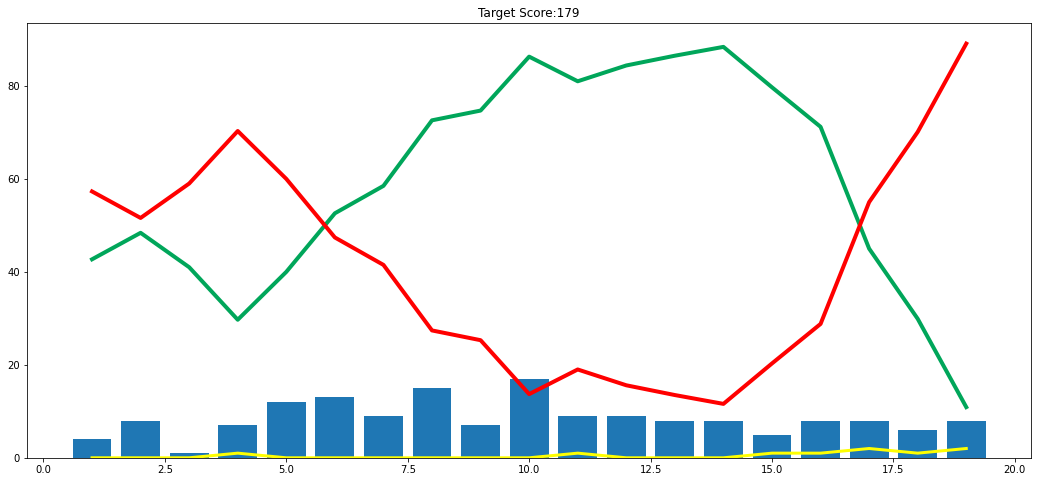

In [78]:
#plot for the match
#mark legend red lose prob green win prob

plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target Score:' + str(target))

### Files for Heroku Deployment

In [80]:
#teamslist 
teamlist

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Delhi Capitals',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals']

In [81]:
#name of cities 
delivdf['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [82]:
#pipe of object to pkl
import pickle
pickle.dump(pipe,open('predpipe.pkl','wb'))

**Sujith Narayanan**<br>
https://github.com/sujithnarayanan95